This notebook is for the chapter clustering task.

# Importation

In [12]:
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
#TODO change here the path to your data folder
data_path='./data'

In [3]:
#Importing the X and y
with open(data_path+'/X2.pkl', 'rb') as f:
    X=pickle.load(f)

with open(data_path+'/y2.pkl', 'rb') as f:
    y=pickle.load(f)

In [4]:
#Building our train test and validation set
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_pretrain, y_pretrain, test_size=0.2, random_state=42)

# Pre-processing

### Doc2Vec distributed bag of words

In [6]:
# tagged data: each doc number is a label
tagged_data = [TaggedDocument(words=doc,
                              tags=[str(i)]) for i, doc in enumerate(X_train)]
# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=2, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [7]:
# get the document vectors
X_train_vec = [model.infer_vector(doc) for doc in tqdm(X_train)]
X_valid_vec = [model.infer_vector(doc) for doc in tqdm(X_valid)]
X_test_vec = [model.infer_vector(doc) for doc in tqdm(X_test)]

100%|██████████| 2000/2000 [09:54<00:00,  3.36it/s]


### Doc2Vec distributed memory

In [8]:
# train the Doc2vec model
model2 = Doc2Vec(vector_size=20, min_count=2, epochs=50, dm=1)
model2.build_vocab(tagged_data)
model2.train(tagged_data,
            total_examples=model2.corpus_count,
            epochs=model2.epochs)

In [9]:
# get the document vectors
X_train_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_train)]
X_valid_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_valid)]
X_test_vec2 = [model2.infer_vector(doc) for doc in tqdm(X_test)]

100%|██████████| 2000/2000 [08:38<00:00,  3.86it/s]


### Count Vectorizer

In [10]:
def dummy(doc):
    return doc

def preprocess_train_valid(X_train, X_valid):
    vectorizer = CountVectorizer(
            tokenizer=dummy,
            preprocessor=dummy,
        ) 
    X_train_new=vectorizer.fit_transform(X_train)
    X_valid_new=vectorizer.transform(X_valid)
    return (X_train_new, X_valid_new)

In [13]:
X_train_count, X_valid_count=preprocess_train_valid(X_train, X_valid)

/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Model

In [44]:
kmeans = KMeans(n_clusters=3000).fit(X_train_vec)
kmeans2 = KMeans(n_clusters=3000).fit(X_train_vec2)

/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/clea/opt/anaconda3/envs/opht/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
agg_cluster = AgglomerativeClustering(n_clusters=3000).fit(X_train_vec)
agg_cluster2 = AgglomerativeClustering(n_clusters=3000).fit(X_train_vec2)

# Results

### Training set

In [51]:
res={}
for i, title in enumerate(y_train):
    if title not in res:
        res[title]=0
    res[title]+=np.sum(X_train_vec[i]**2)
results_doc=pd.DataFrame.from_dict(res, orient='index').reset_index()
results_doc.columns=['title', 'dist_doc2vec_bow']
results_doc.dist_doc2vec_bow=np.sqrt(results_doc.dist_doc2vec_bow)

In [52]:
res2={}
for i, title in enumerate(y_train):
    if title not in res2:
        res2[title]=0
    res2[title]+=np.sum(X_train_vec2[i]**2)
results_doc2=pd.DataFrame.from_dict(res2, orient='index').reset_index()
results_doc2.columns=['title', 'dist_doc2vec_dm']
results_doc2.dist_doc2vec_dm=np.sqrt(results_doc2.dist_doc2vec_dm)

In [53]:
clusters1=kmeans.predict(X_train_vec)
clusters2=kmeans2.predict(X_train_vec2)
clusters3=agg_cluster.fit_predict(X_train_vec)
clusters4=agg_cluster2.fit_predict(X_train_vec2)

In [54]:
results=pd.DataFrame({'kmeans_cluster':clusters1, 'kmeans_cluster2':clusters2,
                      'agg_cluster':clusters3,  'agg_cluster2':clusters4, 'title':y_train}).groupby('title').agg({'kmeans_cluster':[pd.Series.count, pd.Series.nunique],  
                                                                                                                    'kmeans_cluster2':pd.Series.nunique,
                                                                                                                    'agg_cluster':pd.Series.nunique,'agg_cluster2':pd.Series.nunique,})
results.columns=['nb_chapters', 'clust_kmeans_bow', 'clust_kmeans_dm','clust_agg_bow', 'clust_agg_dm']
results=results.merge(results_doc, on='title')
results=results.merge(results_doc2, on='title')
results.sort_values('nb_chapters', ascending=False).head(10)

,title,nb_chapters,clust_kmeans_bow,clust_kmeans_dm,clust_agg_bow,clust_agg_dm,dist_doc2vec_bow,dist_doc2vec_dm
2841,the poetical works of thomas hood,43,5,8,7,6,34.364055,34.298156
3423,works of robert burns,41,7,12,9,9,42.541843,42.795527
967,historical novels,30,24,24,23,24,127.644349,128.337133
1647,os lusadas,28,2,2,2,2,16.860883,17.194803
1733,plutarchs lives volume ii,16,10,8,7,10,48.601121,48.555686
3359,websters unabridged dictionary,16,10,8,9,9,125.489721,121.696066
2105,the aeneid of virgil,15,5,7,3,4,23.146636,23.333427
1734,plutarchs lives volume iii,14,7,6,7,8,47.947008,48.440054
236,anna karenina,14,13,12,12,13,73.336017,73.429818
480,ciceros tusculan disputations,14,9,7,8,8,42.600194,42.514088


<Axes: xlabel='dist_doc2vec_bow', ylabel='Count'>

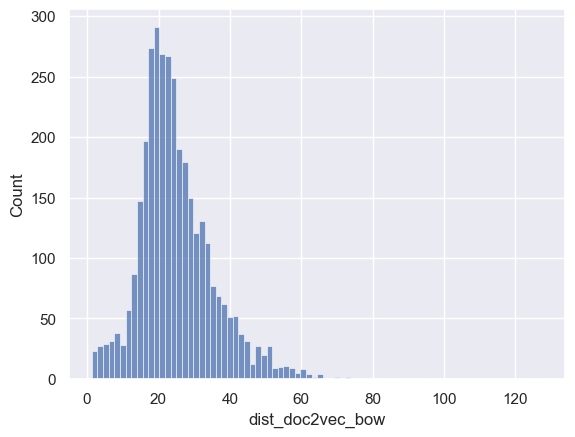

In [72]:
fig,ax=plt.subplots()
sns.histplot(results['dist_doc2vec_bow'])
#ax.set_title('Distribution of the doc2vec distance for chapters embeddings within a same book')

In [63]:
#Average distance between cluster centers
np.mean(euclidean_distances(kmeans.cluster_centers_))

28.101057878518315

In [64]:
np.mean(euclidean_distances(kmeans2.cluster_centers_))

27.96861135781652

In [65]:
results['clust_kmeans_bow'].mean()

1.6275079965106136

In [67]:
results['clust_kmeans_dm'].mean()

1.631578947368421

In [68]:
results['clust_agg_bow'].mean()

1.6184937481826112

In [69]:
results['clust_agg_dm'].mean()

1.615295143937191

In [15]:
results['dist_doc2vec'].describe()

count    3860.000000
mean       26.026915
std        11.466998
min         1.272924
25%        18.588702
50%        24.000248
75%        31.859452
max       133.120058
Name: dist_doc2vec, dtype: float64

### Validation set and model selection

In [ ]:
res={}
for i, title in enumerate(y_valid):
    if title not in res:
        res[title]=0
    res[title]+=np.sum(X_valid_vec[i]**2)
results_doc=pd.DataFrame.from_dict(res, orient='index').reset_index()
results_doc.columns=['title', 'dist_doc2vec']
results_doc.dist_doc2vec=np.sqrt(results_doc.dist_doc2vec)

### Test set

In [17]:
res_t={}
for i, title in enumerate(y_test):
    if title not in res_t:
        res_t[title]=0
    res_t[title]+=np.sum(X_test_vec[i]**2)
results_doc_t=pd.DataFrame.from_dict(res_t, orient='index').reset_index()
results_doc_t.columns=['title', 'dist_doc2vec']
results_doc_t.dist_doc2vec=np.sqrt(results_doc_t.dist_doc2vec)

In [18]:
results2=pd.DataFrame({'cluster':clusters_t, 'title':y_test}).groupby('title').agg([pd.Series.count, pd.Series.nunique])
results2.columns=['nb_chapters', 'nb_clusters']
results2=results2.merge(results_doc_t, on='title')
results2.sort_values('nb_chapters', ascending=False).head(10)

,title,nb_chapters,nb_clusters,dist_doc2vec
1244,the poetical works of thomas hood,14,4,14.051041
1503,works of robert burns,14,8,22.735657
1479,websters unabridged dictionary,10,5,61.323238
729,os lusadas,10,1,8.581459
923,the aeneid of virgil,9,5,20.930494
418,historical novels,8,7,44.272198
774,plutarchs lives volume iii,7,4,26.335530
935,the antiquities of the jews,7,7,53.150846
201,childe harolds pilgrimage,7,4,14.120943
370,good sense,6,4,22.149982


In [19]:
results2['nb_clusters'].describe()

count    1509.000000
mean        1.242545
std         0.614388
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: nb_clusters, dtype: float64

In [20]:
results2['dist_doc2vec'].describe()

count    1509.000000
mean       15.795216
std         6.466926
min         1.173207
25%        11.875908
50%        14.767870
75%        18.512836
max        61.323238
Name: dist_doc2vec, dtype: float64